# MNIST Dataset Preparataion

In [1]:
import tensorflow as tf
from tensorflow import keras

(x_train, _), (_, _) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
print(x_train.dtype)
x_train.shape

uint8


(60000, 28, 28)

### Reshape the data to `(60000, 28, 28, 1)` and change the type to `float32`.

In [3]:
x_train = x_train[:, :, :, None].astype('float32')

print(x_train.dtype)
x_train.shape

float32


(60000, 28, 28, 1)

### Normalize the data between `[-1, 1]`.

In [4]:
# 255/2 = 127.5
x_train = (x_train-127.5) / 127.5

print(x_train.max())
print(x_train.min())

1.0
-1.0


### Convert the data to `tf.data.Dataset` object, then, suffle and batch the data.

In [5]:
data = tf.data.Dataset.from_tensor_slices(x_train)

data = data.shuffle(buffer_size=x_train.shape[0], reshuffle_each_iteration=True).batch(128)

# Modeling

In [6]:
from tensorflow.keras.layers import Reshape, Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout, Flatten
from keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

### Generator and Discriminator Model

In [7]:
noiseDim = 128

In [8]:
generator = Sequential([
    Dense(7*7*256, use_bias=False, input_shape=(noisDim,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((7, 7, 256)),

    # parameters names --->>>> filters, kernel_size, strides, padding
    Conv2DTranspose(128, 5, 1, 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(32, 5, 2, 'same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(1, 5, 2, 'same', use_bias=False, activation='tanh')
])

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1605632   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [10]:
discriminator = Sequential([
    # parameters names --->>>> filters, kernel_size, strides, padding
    Conv2D(64, 5, 2, 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Conv2D(128, 5, 2, 'same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Flatten(),
    Dense(1, activation='sigmoid')
])

### Models Losses and Optimizers

In [11]:
BCELoss = BinaryCrossentropy(from_logits=True)

def genLoss(fake_imgs):
    return BCELoss(tf.ones_like(fake_imgs), fake_imgs)

def disLoss(real_imgs, fake_imgs):
    realLoss = BCELoss(tf.ones_like(real_imgs), real_imgs)
    fakeLoss = BCELoss(tf.zeros_like(fake_imgs), fake_imgs)
    return realLoss + fakeLoss

In [12]:
genOptimizer = Adam()
disOptimizer = Adam()

# Training

### Save Checkpoints

In [13]:
import os

ckpt_dir = './training_checkpoints/ckpt'
if not os.path.exists(ckpt_dir): os.makedirs(ckpt_dir)

In [14]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer=genOptimizer,
    discriminator_optimizer=disOptimizer,
    generator=generator,
    discriminator=discriminator
)

### Training Phase

In [15]:
import time

for epoch in range(50):
    start = time.time()
    noise_vecs = tf.random.normal((128, noiseDim))

    for real_imgs in data:  # Remember: the batch size is 128
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            generated_imgs = generator(noise_vecs, training=True)

            disc_real_output = discriminator(real_imgs, training=True)
            disc_fake_output = discriminator(generated_imgs, training=True)

            gen_loss = genLoss(disc_fake_output)
            dis_loss = disLoss(disc_real_output, disc_fake_output)

        genGradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        genOptimizer.apply_gradients(zip(genGradients, generator.trainable_variables))

        disGradients = dis_tape.gradient(dis_loss, discriminator.trainable_variables)
        disOptimizer.apply_gradients(zip(disGradients, discriminator.trainable_variables))

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0: checkpoint.save(file_prefix = ckpt_dir)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(f'Generator Loss: {tf.reduce_mean(gen_loss)} --------------- Discrimator Loss: {tf.reduce_mean(dis_loss)}\n')

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 73.03445386886597 sec
Generator Loss: 3.6088013648986816 --------------- Discrimator Loss: 0.19880351424217224

Time for epoch 2 is 51.809582233428955 sec
Generator Loss: 2.3641483783721924 --------------- Discrimator Loss: 0.6994775533676147

Time for epoch 3 is 49.620569944381714 sec
Generator Loss: 3.6840295791625977 --------------- Discrimator Loss: 0.441979318857193

Time for epoch 4 is 49.80181837081909 sec
Generator Loss: 2.411440849304199 --------------- Discrimator Loss: 0.7110388875007629

Time for epoch 5 is 53.692999601364136 sec
Generator Loss: 2.128495454788208 --------------- Discrimator Loss: 1.0599100589752197

Time for epoch 6 is 51.75793957710266 sec
Generator Loss: 1.4922096729278564 --------------- Discrimator Loss: 1.0503432750701904

Time for epoch 7 is 52.380656242370605 sec
Generator Loss: 1.9663774967193604 --------------- Discrimator Loss: 0.6277605891227722

Time for epoch 8 is 52.33690690994263 sec
Generator Loss: 1.8208001852035522 ----

In [15]:
# checkpoint.restore(tf.train.latest_checkpoint(ckpt))

# Predictions

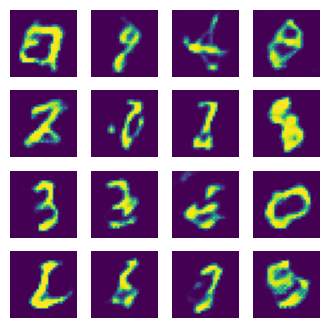

In [18]:
import matplotlib.pyplot as plt

# Save and Load the generator weights
# generator.save_weights('generator_weights.h5')
# generator.load_weights('generator_weights.h5')

# Generate some fake images using the trained generator
sample_noise = tf.random.normal([16, noiseDim])
generated_images = generator(sample_noise, training=False)

fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i]*0.5 + 0.5).numpy())
    plt.axis('off')
plt.show()